In [1]:
import torchvision as tv
import numpy as np
from matplotlib.pyplot import imshow


In [2]:
import base64
from PIL import Image

In [3]:
mnist = tv.datasets.MNIST('.')

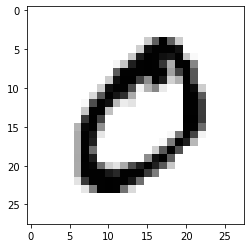

In [5]:
imshow(np.asarray(mnist[1][0]), cmap='gray_r') 

In [6]:
with open('delta.png.base64', 'r') as f:
    data = f.read()

In [7]:
import tempfile

def base64_to_mnist(raw_data):
    trimmed = raw_data.split(',', 1)[-1]
    asbytes = base64.b64decode(trimmed)
    
    with tempfile.NamedTemporaryFile() as img_buffer:
        img_buffer.write(asbytes)
        as_pil = Image.open(img_buffer)
        as_pil.load()
        
    as_pil = as_pil.resize((128, 128)) # magic mnist-model friendly format
    as_pil = as_pil.convert('L')
    return as_pil

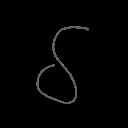

In [8]:
base64_to_mnist(data)